Write an algorithm that extracts / identifies the epithelium layer in the conjunctival lesion image.

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage import io

In [4]:
image_paths = ['h2114153h&e.tif', 'h2114153melan.tif', 'h2114153melan2.tif', 'h2114153sox10.tif']
ignore = ['h2114154h&e.tif', 'h2114154h&e2.tif', 'h2114154melan.tif', 'h2114154melan2.tif', 'h2114154sox10.tif',
               'h2114156h&e.tif', 'h2114156h&e2.tif', 'h2114156melan.tif', 'h2114156melan2.tif', 'h2114156sox10.tif',
               'h2114157h&e.tif', 'h2114157sox10.tif',
               'h2114158h&e.tif', 'h2114158h&e2.tif', 'h2114158melan.tif', 'h2114158melan2.tif']

def compare_images_pairwise(image_paths):

    histograms = []
    images = []

    # loop through to do more than two images
    for path in image_paths:
        # Load the image
        image = cv2.imread(path)
        if image is None:
            print(f"Error loading image: {path}")
            continue

        # HSV configuration
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Compute the histogram for the image
        hist = cv2.calcHist([image_hsv], [0, 1, 2], None, [50, 60, 60], [0, 180, 0, 256, 0, 256])
        cv2.normalize(hist, hist)

        # histogram list allows you to go through more than one
        histograms.append(hist)
        images.append(path)

    # comparison
    for i in range(len(histograms)):
        for j in range(i + 1, len(histograms)):
            similarity = cv2.compareHist(histograms[i], histograms[j], cv2.HISTCMP_CORREL)
            print(f'Similarity between {images[i]} and {images[j]}: {similarity}')
            print(f'Similarity between the two images: {similarity}')

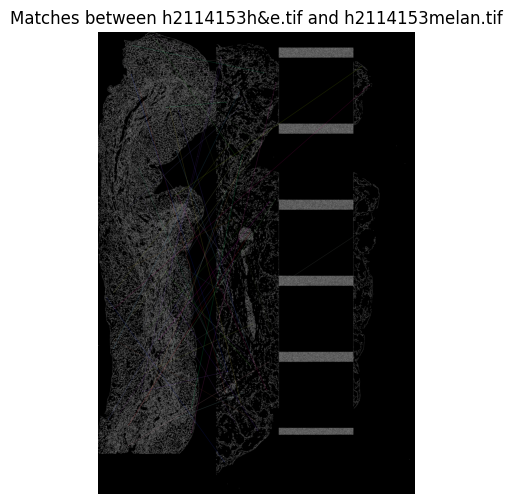

Structural Similarity between h2114153h&e.tif and h2114153melan.tif: 0.0882
Structural Similarity for patch between h2114153h&e.tif and h2114153melan.tif: 0.0001


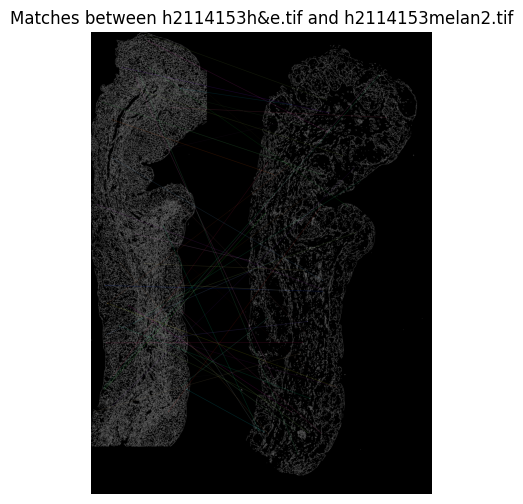

Structural Similarity between h2114153h&e.tif and h2114153melan2.tif: 0.0407
Structural Similarity for patch between h2114153h&e.tif and h2114153melan2.tif: 0.0001


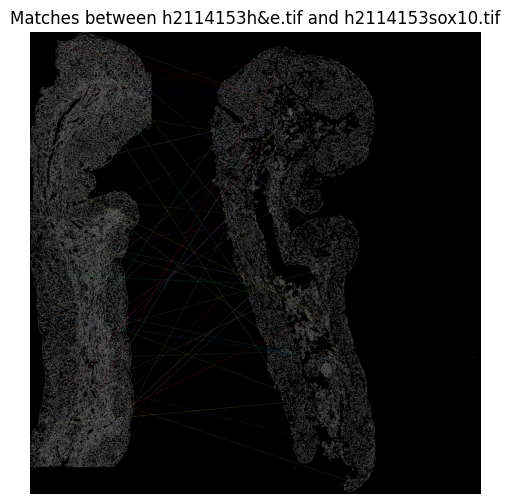

Structural Similarity between h2114153h&e.tif and h2114153sox10.tif: 0.0566
Structural Similarity for patch between h2114153h&e.tif and h2114153sox10.tif: 0.0001


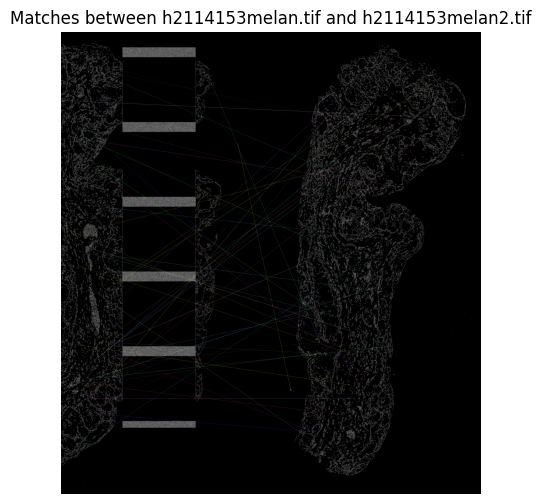

Structural Similarity between h2114153melan.tif and h2114153melan2.tif: 0.3683
Structural Similarity for patch between h2114153melan.tif and h2114153melan2.tif: 0.2034


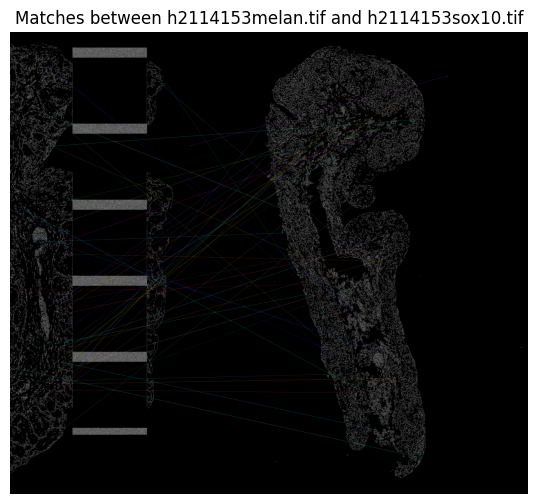

Structural Similarity between h2114153melan.tif and h2114153sox10.tif: 0.0004
Structural Similarity for patch between h2114153melan.tif and h2114153sox10.tif: 0.0001


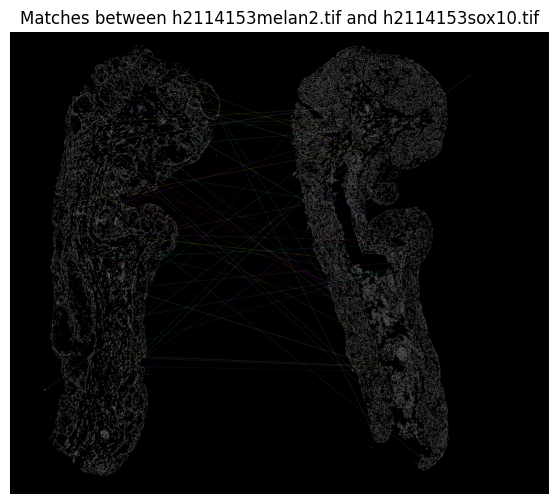

Structural Similarity between h2114153melan2.tif and h2114153sox10.tif: 0.1644
Structural Similarity for patch between h2114153melan2.tif and h2114153sox10.tif: 0.0001


In [6]:
# this was altered to work on lauren's code, this upload was just to make sure that this worked on google collab properly due to large file sizes and minimal runtime as well as bad service
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Use this to show images in Colab

def compare_images(image_paths):
    # ORB feature detector
    orb = cv2.ORB_create()

    # Loop through the image pairs
    for i in range(len(image_paths)):
        for j in range(i + 1, len(image_paths)):

            # Load two images in grayscale
            img1 = cv2.imread(image_paths[i], 0)
            img2 = cv2.imread(image_paths[j], 0)

            if img1 is None or img2 is None:
                print(f"Error loading images {image_paths[i]} or {image_paths[j]}")
                continue

            # Edge Detection
            edges1 = cv2.Canny(img1, 100, 200)
            edges2 = cv2.Canny(img2, 100, 200)

            # Feature Matching using ORB
            keypoints1, descriptors1 = orb.detectAndCompute(edges1, None)
            keypoints2, descriptors2 = orb.detectAndCompute(edges2, None)

            # Brute Force Matcher with cross-check
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(descriptors1, descriptors2)
            matches = sorted(matches, key=lambda x: x.distance)

            # Visualize the matched features using matplotlib
            matched_img = cv2.drawMatches(edges1, keypoints1, edges2, keypoints2, matches[:50], None, flags=2)

            plt.figure(figsize=(10, 6))
            plt.title(f'Matches between {image_paths[i]} and {image_paths[j]}')
            plt.imshow(matched_img, cmap='gray')
            plt.axis('off')
            plt.show()

            if len(matches) > 10:
                # Get keypoints from matches
                src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

                # Estimate Affine Transform
                M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

                # Align second image with the first
                aligned_img2 = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

                # Structural Similarity Index (SSIM)
                similarity_score, diff = ssim(img1, aligned_img2, full=True)
                print(f'Structural Similarity between {image_paths[i]} and {image_paths[j]}: {similarity_score:.4f}')

                x, y, w, h = 100, 100, 50, 50
                patch1 = img1[y:y+h, x:x+w]
                patch2 = aligned_img2[y:y+h, x:x+w]

                patch_similarity, patch_diff = ssim(patch1, patch2, full=True)
                print(f'Structural Similarity for patch between {image_paths[i]} and {image_paths[j]}: {patch_similarity:.4f}')

            else:
                print(f"Not enough matches between {image_paths[i]} and {image_paths[j]}")

image_paths = ['h2114153h&e.tif', 'h2114153melan.tif', 'h2114153melan2.tif', 'h2114153sox10.tif']

# Compare images pairwise
compare_images(image_paths)
